<a href="https://colab.research.google.com/github/aviraltyagi/DeepLearningArchitectures/blob/main/GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, concatenate, Layer, Input, Add, Dense, Flatten, ZeroPadding2D, BatchNormalization, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPool2D, Activation
from tensorflow.keras.models import Model
from keras.initializers import glorot_uniform
from keras.regularizers import l2
import typing

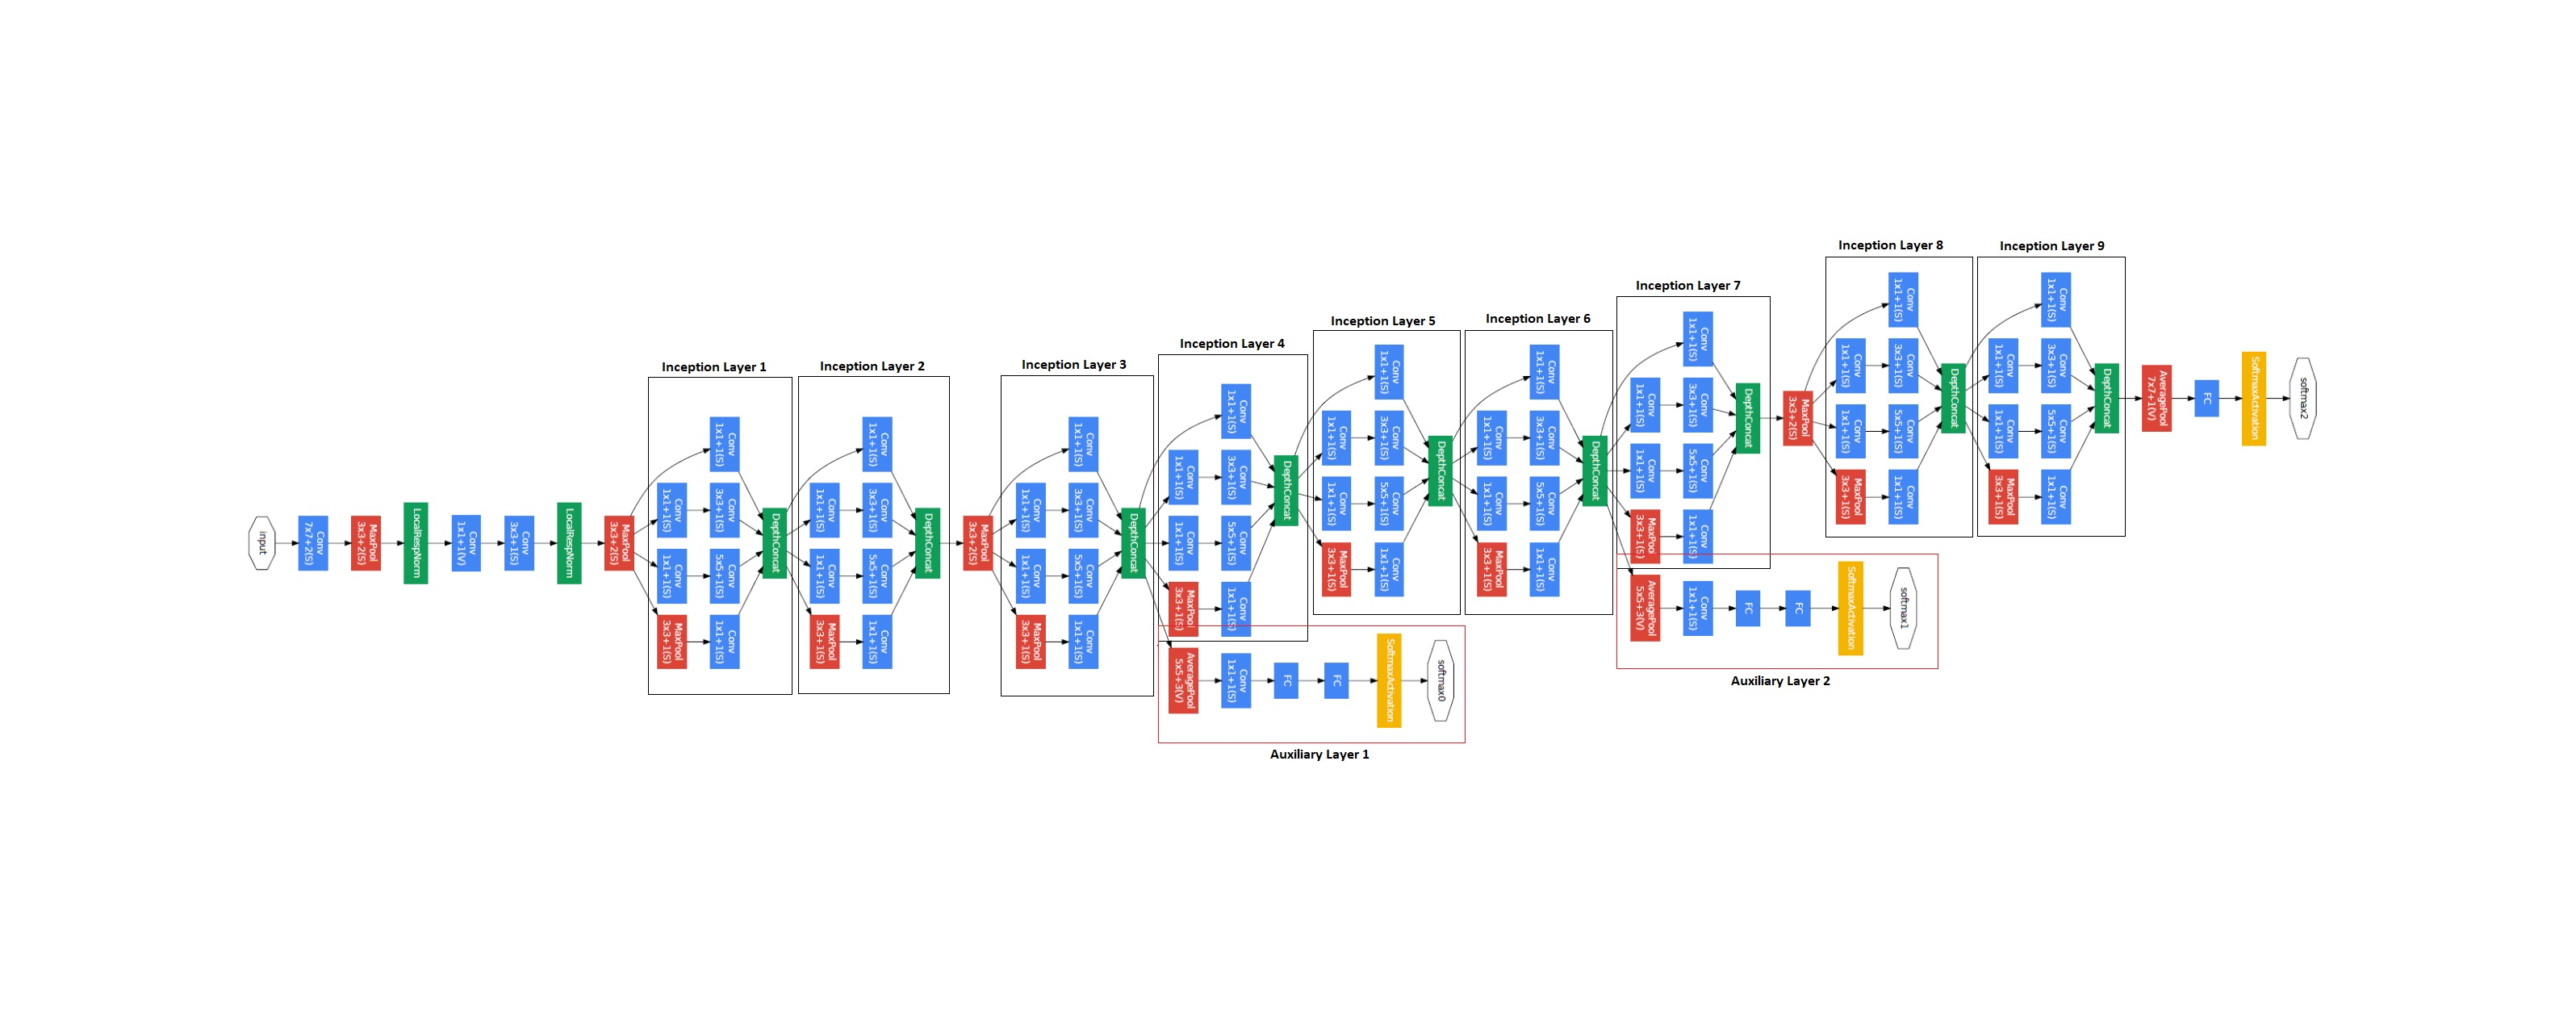

In [ ]:
class LRN2D(Layer):
    """
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """

    def __init__(self, alpha=0.0001,k=1,beta=0.75,n=3):
        if n % 2 == 0:
            raise NotImplementedError("LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__()
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        return tf.nn.lrn(X)

    def get_config(self):
        return {"alpha": self.alpha,
                "k": self.k,
                "beta": self.beta,
                "n": self.n}

In [ ]:
class CustomModule():
  def inception_module(input, filter1x1, filter3x3, filter5x5, reduce1x1, reduce3x3, reduce5x5, name):
    conv1x1 = Conv2D(filters= filter1x1, kernel_size= (1,1), padding= 'same', activation= 'relu', name= name + "Conv1x1")(input)
    conv3x3_reduce = Conv2D(reduce3x3, kernel_size=(1,1), padding='same', activation='relu', name= name + "Conv3x3_reduce")(input)
    conv5x5_reduce = Conv2D(reduce5x5, kernel_size=(1,1), padding='same', activation='relu', name= name + "conv5x5_reduce")(input)
    maxPool = MaxPooling2D(pool_size= (1,1), strides= (1,1), name= name + "MaxPool")(input)

    conv1x1_L2 = Conv2D(filters= reduce1x1, kernel_size= (1,1), padding= 'same', activation= 'relu', name= name + "Conv1x1_L2")(maxPool)
    conv3x3_L2 = Conv2D(filters= filter3x3, kernel_size= (3,3), padding= 'same', activation= 'relu', name= name + "Conv3x3")(conv3x3_reduce)
    conv5x5_L2 = Conv2D(filters= filter5x5, kernel_size= (5,5), padding= 'same', activation= 'relu', name= name + "Conv5x5")(conv5x5_reduce)

    out = concatenate([conv1x1, conv1x1_L2, conv3x3_L2, conv5x5_L2], name= name + "out")

    return out

  def auxiliary_module(input, filter1x1, auxOut, name):
    avgPool = AveragePooling2D(pool_size= (5,5), strides= (3,3), padding= 'same', name= name + "AvgPool")(input)
    conv1x1 = Conv2D(filters= filter1x1, kernel_size= (1,1), padding= 'same', activation= 'relu', kernel_regularizer= l2(0.0002), name= name + "Conv1x1")(avgPool)
    fc = Flatten(name= name + "Flatten")(conv1x1)
    fc = Dense(units= 1024, activation= 'relu', kernel_regularizer=l2(0.0002), name= name + "FC1")(fc)
    fc = Dropout(rate= 0.7)(fc)
    fc = Dense(units= auxOut, activation= 'softmax', kernel_regularizer=l2(0.0002), name= name + "out")(fc)

    return fc

In [ ]:
class CustomGoogleNet(Model):
  def GoogleNet(input_shape: typing.Tuple[int], classes: int) -> Model:
    x_input = Input(shape= input_shape)
    

    x = Conv2D(filters=64, kernel_size= (7,7), strides= (2,2), padding= 'same', activation= 'relu', name= 'Stem_Conv1')(x_input)
    x = MaxPooling2D(pool_size= (3,3), strides= (2,2), padding= 'same', name= 'Stem_MaxPool1')(x)

    # Loacal response Normal code
    x = LRN2D()(x)

    x = Conv2D(filters= 64, kernel_size= (1,1), strides= (1,1), padding= 'same', activation= 'relu', kernel_regularizer = l2(0.0002), name= 'Stem_Conv2')(x)
    x = Conv2D(filters= 192, kernel_size= (3,3), strides= (1,1), padding='same', activation= 'relu', kernel_regularizer = l2(0.0002), name= 'Stem_Conv3')(x)

    # Local response Normal code
    x = LRN2D()(x)

    x = MaxPooling2D(pool_size= (3,3), strides= (2,2), padding= 'same', name= 'Stem_MaxPool2')(x)

    # Inception Module 1
    x = CustomModule.inception_module(x, filter1x1= 64, filter3x3= 128, filter5x5=32, reduce1x1= 32, reduce3x3= 96, reduce5x5= 16, name= "IM1_")

    # Inception Module 2
    x = CustomModule.inception_module(x, filter1x1= 128, filter3x3= 192, filter5x5=96, reduce1x1= 64, reduce3x3= 128, reduce5x5= 32, name= "IM2_")

    x = MaxPooling2D(pool_size= (3,3), strides= (2,2), padding= 'same', name= 'MaxPool1')(x)

    # Inception Module 3
    x = CustomModule.inception_module(x, filter1x1= 192, filter3x3= 208, filter5x5=48, reduce1x1= 64, reduce3x3= 96, reduce5x5= 16, name= "IM3_")
    # Auxiliary Module 1
    auxOut1 = CustomModule.auxiliary_module(x, filter1x1= 128,auxOut= 1000, name= "Aux1_")

    # Inception Module 4
    x = CustomModule.inception_module(x, filter1x1= 160, filter3x3= 224, filter5x5=64, reduce1x1= 64, reduce3x3= 112, reduce5x5= 24, name= "IM4_")

    # Inception Module 5
    x = CustomModule.inception_module(x, filter1x1= 128, filter3x3= 256, filter5x5=64, reduce1x1= 64, reduce3x3= 128, reduce5x5= 24, name= "IM5_")

    # Inception Module 6
    x = CustomModule.inception_module(x, filter1x1= 112, filter3x3= 288, filter5x5=64, reduce1x1= 64, reduce3x3= 144, reduce5x5= 32, name= "IM6_")

    # Auxiliary Module 1
    auxOut2 = CustomModule.auxiliary_module(x, filter1x1= 128,auxOut= 1000, name= "Aux2_")

    # Inception Module 7
    x = CustomModule.inception_module(x, filter1x1= 256, filter3x3= 320, filter5x5=128, reduce1x1= 128, reduce3x3= 160, reduce5x5= 32, name= "IM7_")

    x = MaxPooling2D(pool_size= (3,3), strides= (2,2), padding= 'same', name= 'MaxPool2')(x)

    # Inception Module 8
    x = CustomModule.inception_module(x, filter1x1= 256, filter3x3= 320, filter5x5=128, reduce1x1= 128, reduce3x3= 160, reduce5x5= 32, name= "IM8_")

    # Inception Module 9
    x = CustomModule.inception_module(x, filter1x1= 384, filter3x3= 384, filter5x5=128, reduce1x1= 128, reduce3x3= 192, reduce5x5= 48, name= "IM9_")

    x = AveragePooling2D(pool_size= (7,7), strides= (1,1), padding= 'valid', name= "AvgPool")(x)
    x = Flatten()(x)
    x = Dropout(rate= 0.4)(x)
    output = Dense(units= 1000, activation= 'softmax', kernel_regularizer=l2(0.0002))(x)


    model = Model(inputs = x_input, outputs= [auxOut1, auxOut2, output], name= 'GoogleNet')

    # if weights_path:
    #   model.load_weights(weights_path)

    return model

In [ ]:
model = CustomGoogleNet.GoogleNet(input_shape= (224, 224, 3), classes= 6)

In [ ]:
model.summary()

Model: "GoogleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Stem_Conv1 (Conv2D)             (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
Stem_MaxPool1 (MaxPooling2D)    (None, 56, 56, 64)   0           Stem_Conv1[0][0]                 
__________________________________________________________________________________________________
lr_n2d (LRN2D)                  (None, 56, 56, 64)   0           Stem_MaxPool1[0][0]              
__________________________________________________________________________________________